In [5]:
try:
    import simplegui
    print("old school")
except ImportError:
    print("SimpleGUICS2Pygame")
    import SimpleGUICS2Pygame.simpleguics2pygame as simplegui
import math
import random

SimpleGUICS2Pygame


In [6]:
#!pip install SimpleGUICS2Pygame

In [7]:
# Sensor Values
SENSOR_FOV = 10.0 # FOV of each sensor THIS MUST BE A FLOAT!!!!!! 
SENSOR_MAX_R = 100 # max range that each sensor can report
OBSTACLE_RAD = 20 # how big (radius) are the obstacles

In [8]:
# Robot Values
ROBOT_RAD = 30 # how big (radius) is the robot?
SENSOR_ALERT_R = 100 #range within which sensor reports are acted upon
SAFETY_DISTANCE = 50
TURN_SCALE_FACTOR = 2 # how drastic do we want the turns to be



### Helper functions


In [9]:
def dist_and_brg_in_deg(p0, p1):#bearing and distance in degrees between two points
    [x1, y1] = p0
    [x2, y2] = p1
    r = math.sqrt((x1 - x2)**2 + (y1 - y2)**2) # distance
    a = math.degrees(math.atan((y1 - y2)/(x1 - x2 + 0.000000001)))
    #find and correct the quadrant...
    if  x2 >= x1:
        b = 90 + a
    else:
        b = 270 + a
    return r, b

In [10]:
def brg_in_deg(p0, p1):#bearing only in degrees
    [x1, y1] = p0
    [x2, y2] = p1
    a = math.degrees(math.atan((y1 - y2)/(x1 - x2 + 0.000000001)))
    #find and correct the quadrant...
    if  x2 >= x1:
        b = 90 + a
    else:
        b = 270 + a
    return b

In [11]:
def relative_brg(b1, b2):
    rb = b2 - b1
    if rb > 180:
        rb = 360 - rb
    if rb < -180:
        rb += 360
        rb *= -1
    return rb

In [12]:
def dist(p1, p0):#distance only
    return math.sqrt((p1[0] - p0[0])**2+(p1[1]-p0[1])**2)

In [13]:
def create_vector(from_pos, length, brg):       
    u_vec = angle_to_vector(brg)
    #print "generating target line..."
    vec0 = from_pos[0] + length * u_vec[1] 
    vec1 = from_pos[1] - length * u_vec[0]

    return [vec0, vec1]

In [14]:
def angle_to_vector(ang):#resolve angles into vectors
    ang = math.radians(ang)
    return [math.cos(ang), math.sin(ang)]

In [15]:
def rel_brg_fm_offset_sensor(true_hdg, sensor_offset, tgt_brg):
    #given robot's true heading, the sensor offset angle and the
    #true brg of the target, this fn will return the relative brg
    #of the target from the sensor's line of sight
    
    sensor_look_brg = (true_hdg + sensor_offset)%360
    tgt_rel_fm_sensor = tgt_brg - sensor_look_brg

    if tgt_rel_fm_sensor < -180:
        tgt_rel_fm_sensor += 360
    
    
    #print("true_hdg : ",true_hdg)
    #print("sensor_offset : ",sensor_offset)
    #print("tgt_brg : ",tgt_brg)
    #print("tgt_rel_fm_sensor : ",tgt_rel_fm_sensor)
    
    return tgt_rel_fm_sensor

In [16]:
def find_location_onMap(pos):
    location_in_the_grid=[]
    location_in_the_map=[]
    i=0
    i1=0
    loc=0
    loc1=0
    for squares in range(0,10):
        i1=0
        for quare in range(0,10):
            loc=0
            #square.append((i,i1))
            if ((pos[0]>i and pos[0]<=i+50) and (pos[1]>i1 and pos[1]<=i1+50)):
                for rows in range(0,4):
                    loc1=0
                    for col in range(0,4):
                        if ((pos[0]>loc+i and pos[0]<=loc+i+12.5) and (pos[1]>loc1+i1 and pos[1]<=loc1+12.5+i1)):           
                            location_in_the_grid.append(loc)
                            location_in_the_grid.append(loc1)
                            location_in_the_map.append(i)
                            location_in_the_map.append(i1)

                        loc1+=12.5
                    loc+=12.5
            i1+=50
        i+=50
            
    #To to convert to 3x3 grid
    location_in_the_grid[0]=int(location_in_the_grid[0]/12.5)
    location_in_the_grid[1]=int(location_in_the_grid[1]/12.5)
    #To to convert to 5x5 map each sqaure is 100X100 pixel
    location_in_the_map[0]=int(location_in_the_map[0]/50)
    location_in_the_map[1]=int(location_in_the_map[1]/50)
    return location_in_the_map, location_in_the_grid

In [17]:
def policy_finder (mylocation,obs):
    #mylocation_onMap, my_location_onGrid = find_location_onMap(mylocation)
    #obs_location_onMap, obs_location_onGrid = find_location_onMap(obs)
    

    
    direction = random.sample(direction_list,1)[0]
    return direction
                    

## define constants

In [18]:
#define classes

class Sonar:
    def __init__(self, index, FOV, max_r, robot_co):
        #create a instance of this class
        self.pos = [0,0]
        self.index = index
        self.max_r = max_r
        self.offset =  index * FOV #+ FOV/2 # on what relative bearing is this sensor looking?
        self.look_brg = (robot_co + self.offset)%360
        self.vec = [0,0] # just a vector for grpahical ouptut of pings
        self.has_valid_echo = False #indicates if this sonar has a "valid" obstacle in sight
    
    def d_test_checker(self,rel_brg):
        try:
            d_test = math.asin(math.radians(rel_brg))
            return True
        except ValueError as error:
            return False
        
    
    def can_observe(self, robot_co, obstacle_pos, obstacle_rad):
        #if obstacle is within within the max_r of the sensor
        #and within FOV, return True and the distance observed
        #else return False, 0
        
        dist, brg = dist_and_brg_in_deg(self.pos, obstacle_pos)
        
        if dist < self.max_r: #if the object is within max_r....
            rel_brg = rel_brg_fm_offset_sensor(robot_co, self.offset, brg)#rel brg of tgt from sensor LOS
            d_test_checker = self.d_test_checker(rel_brg)
            
            if d_test_checker:
                d_asin = math.asin(math.radians(rel_brg))

                d_test = abs(dist * d_asin )
                if d_test < OBSTACLE_RAD + ROBOT_RAD: 
                    self.has_valid_echo = True
                    return True, dist # if the object is within min allowed lateral separation
                else:
                    self.has_valid_echo = False
                    return False, 0 # ignore it

            else:
                    self.has_valid_echo = False
                    return False, 0 # ignore it
            
        else:#if the object is outside max_r of this sonar...ignore it
            self.has_valid_echo = False
            return False, 0
    
    
    def ping_simulated(self, obstacle_list, robot_co):
        #from robot position and robot_co, run through obs_list
        #return the distance to closest object within 
        #FOV and within self.max_r of THIS SENSOR
        # range all the obstacles in view, find the nearest
        
        range_list = []
        for obs in obstacle_list:# find objects within max_r and inside FOV
            #print "pinging for robot_co:", robot_co
            can_observe, d = self.can_observe(robot_co, obs, OBSTACLE_RAD)
            
            if can_observe:
                range_list.append(d) 
        if len(range_list) > 0:
            self.output = min(range_list)- SAFETY_DISTANCE
        else:
            self.output = SENSOR_MAX_R
            
        
        
    def update(self, platform_pos, platform_co, obstacle_list):
              
        #update own parameters
        self.pos = platform_pos
        
        self.look_brg = (platform_co + self.offset)%360
        
        #calculate output of this sensor
        
        self.ping_simulated(obstacle_list, platform_co)
        
        self.vec = create_vector(self.pos, self.output + ROBOT_RAD, self.look_brg)#calculate distance vector for drawing on canvas
       
        #print("sensor index:", self.index)
        #print("sense range: ",self.output)
        #print(" look brg:", self.look_brg)
        
    def draw(self, canvas,robot_co): # draw the sensor's output
        #if self.has_valid_echo:
        self.look_brg = (robot_co + self.offset)%360
        self.ping_simulated(obstacle_list, robot_co)
        self.vec = create_vector(self.pos, self.output + ROBOT_RAD, self.look_brg)
        
        #canvas.draw_line(self.pos,self.co_vec, 1, 'lime')
        #canvas.draw_text(str(self.index),(self.co_vec[0]+4, self.co_vec[1]+4), 10, "lime"),
        
        
        canvas.draw_line(self.pos,self.vec, 1, 'lime')
        canvas.draw_text(str(self.index),(self.vec[0]+4, self.vec[1]+4), 10, "lime"),
        #print self.index, " VE:" , self.has_valid_echo

In [19]:
class Sonar_Array:
    def __init__(self, n_sensors, SENSOR_FOV, SENSOR_MAX_R, robot_co):
        self.sonar_list = []
        self.need_diversion_flag = False
        
        i_pos = [x for x in range(1, int(n_sensor/2) + 1)]
        i_neg = [x for x in range(-int(n_sensor/2) , 0)]
        i_pos = i_pos[::-1]
        i_neg = i_neg[::-1]
        i_pos.extend(i_neg)
        self.sensor_alert_list = {}
        self.sensor_danger_range = {}

        for i in i_pos:#create a list of individual sonars...
            self.sonar_list.append(Sonar(i, SENSOR_FOV, SENSOR_MAX_R, robot_co))
            self.sensor_alert_list[i] = False
            self.sensor_danger_range[i] = 0
            
      
    def update(self, robot_pos, robot_co, obstacle_list):
        #update sonar array
        for sonar in self.sonar_list:#update output of each sensor
            
            sonar.update(robot_pos, robot_co, obstacle_list)
           

        
        self.check_and_update_sensor_status(robot_pos,robot_co)
        return self.sensor_alert_list,self.sensor_danger_range
        
    def check_and_update_sensor_status(self, robot_pos, robot_co):
        #process data by the weighted sum method and 
        #return (1) whether turn is required or not (2) index of recommended sonar LOS to turn to
        sum_d = 0
        sum_wt = 0
        alert = False


        #update sensor_check_list and danger_range

        for sonar in self.sonar_list:

            if sonar.output < SENSOR_ALERT_R:#has this sonar found anything in danger zone?
                alert = True
                self.sensor_alert_list[sonar.index] = True
                self.sensor_danger_range[sonar.index] = sonar.output
                
                break # processing completed
            else: #no obstacle in danger zone
                rec_index = 0


                
        
        
    def draw(self, canvas,robot_co):
        for sonar in self.sonar_list:
            sonar.draw(canvas,robot_co)

In [20]:
class Robot:
    def __init__(self, pos, co, n_sensor):
        self.goal_pos = goal_pos
        self.pos = pos
        self.init_pos = pos
        
        self.history = [pos]
        
        self.co = co
        self.init_co = co
        self.spd = 2 #10 # robot speed in pixels/ step
        self.s_array = Sonar_Array(n_sensor, SENSOR_FOV, SENSOR_MAX_R, self.co)
        self.goal_brg = brg_in_deg(self.pos, goal_pos)
        self.obstacles_in_view = []
        self.is_sensor_alert = False
        self.direction_list = ['U','UR','R','RD','D','DL','L','LU']
        
        
        
        # data points
        self.max_bound = 500
        self.min_bound = 0
        self.process_count = 0
        self.data_points = []
        self.cur_data_points = []
        self.data_losses = []
        self.choosed_direction = []
        
        # model work
        self.model = None
        
    
    def restart_robot(self):
        self.process_count = 0
        self.pos = self.init_pos
        self.co = self.init_co
        
        self.history = [self.pos]
        self.data_points = []
        self.cur_data_points = []
        self.data_losses = []
        self.choosed_direction = []
        
    
    
    
    def get_obstacles_in_view(self):
        return self.obstacles_in_view
    
    def d_test_checker(self,rel_brg):
        try:
            d_test = math.asin(math.radians(rel_brg))
            return True
        except ValueError as error:
            return False

    def policy_finder(self,sensor_alert_list, sensor_range_list):
        data_point1 = []
        
        #update goal direction
        self.goal_brg = brg_in_deg(self.pos, goal_pos)
        self.goal_brg = float("{:.2f}".format(self.goal_brg))
        data_point1.append(self.goal_brg)
        data_point1.append(int(self.goal_pos[0]))
        data_point1.append(int(self.goal_pos[1]))
        
        
        #calculate robot location and co
        u_vec = angle_to_vector(self.co)
        temp_pos0 = self.pos[0] + (self.spd  * u_vec[1])
        temp_pos1 = self.pos[0] - ( self.spd  * u_vec[0])
        
        temp_pos0 = int(temp_pos0)
        temp_pos1 = int(temp_pos0)
        temp_co = float("{:.2f}".format(self.co))
        
        data_point1.append(temp_co)
        data_point1.append(temp_pos0)
        data_point1.append(temp_pos1)
        
        
        for key in sensor_alert_list.keys():
            if sensor_alert_list[key]:
                data_point1.append(1)
            else:
                data_point1.append(0)
            
            sensor_range = float("{:.2f}".format(sensor_range_list[key]))
            data_point1.append(sensor_range)
            
        self.cur_data_points  = data_point1
        self.data_points.append(data_point1)
        
        #direction = random.sample(self.direction_list,1)[0]
        direction = self.get_model_prediction(self.cur_data_points)
        cur_loss = self.calcuate_reward(data_point1)
        self.data_losses.append(cur_loss)
        self.choosed_direction.append(direction)
        return direction
    
    
    
    def get_model_prediction(self,cur_data_points):
        predicted_list = self.model.predict([cur_data_points])[0]
        predicted_label = self.class_rank(predicted_list,self.direction_list)
        return predicted_label
    
    
    def calculate_offset(self,sensor_alert_list, sensor_range):
        action = self.policy_finder(sensor_alert_list, sensor_range)
        offset = 0
        if action == 'UR':
            offset=45                       
        elif action == 'R':
            offset=90
        elif action == 'RD':
            offset=90
        elif action == 'D':
            offset=180
        elif action == 'DL':
            offset=225
        elif action == 'L':
            offset=270
        elif action == 'LU':
            offset=315
        elif action == 'U':
            offset = 359
        
        updated_robot_col=(offset%self.co)+self.co
        return updated_robot_col
    
    
    def get_sensor_alert(self,sensor_alert_list):
        for key,value in sensor_alert_list.items():
            if value:
                return True
        return False
    
    
    def update(self):
  
        self.process_count = self.process_count+1
        self.obstacles_in_view = [] #delete all the old obstacles in view
        for obs in full_obstacle_list:
            if dist(self.pos, obs) < SENSOR_MAX_R:
                self.obstacles_in_view.append(obs)
                

                
        #re-calculate direction to goal
        self.goal_brg = brg_in_deg(self.pos, goal_pos)
        
        sensor_alert_list, sensor_range = self.s_array.update(self.pos, self.goal_brg, self.obstacles_in_view)
        self.is_sensor_alert = self.get_sensor_alert(sensor_alert_list)

                
        #while not self.path_is_clear() or  self.is_sensor_alert:

            #re-estimate sensor output by weighted sum method

        sensor_alert_list, sensor_range = self.s_array.update(self.pos, self.goal_brg, self.obstacles_in_view)
        self.is_sensor_alert = self.get_sensor_alert(sensor_alert_list)

        updated_robo_co1 = self.calculate_offset(sensor_alert_list, sensor_range)

        if self.check_can_move(2,updated_robo_co1):
            self.co = updated_robo_co1
            self.move(2)
            return
        else:
            return



            
    def class_rank(self,predicted_list,class_list):
        index = 0
        maxValue = predicted_list[0]
        for i,temp in enumerate(predicted_list):
            if maxValue < int(temp):
                maxValue = int(temp)
                index = i
        return class_list[index]


    def path_is_clear(self):#return True if there is a clear path to the goal
        goal_brg = brg_in_deg(self.pos, goal_pos)
        for obs in self.obstacles_in_view:
            if dist(self.pos, goal_pos) > dist(self.pos, obs):
                d_obs, obs_brg = dist_and_brg_in_deg(self.pos, obs)
                rel_brg = abs(relative_brg(goal_brg, obs_brg))
                d_test_checker = self.d_test_checker(rel_brg)
                if d_test_checker:
                    d_lateral = abs(d_obs * math.asin(math.radians(rel_brg)))
                    if d_lateral < OBSTACLE_RAD + ROBOT_RAD: 
                        return False    
        return True
    
    def calcuate_reward(self,data_points):
        cur_data = data_points
        goal_x = cur_data[1]
        goal_y = cur_data[2]

        robot_x = cur_data[4]
        robot_y = cur_data[5]
        
        init_x = self.init_pos[0]
        init_y = self.init_pos[1]
       
        _dist_roboty_and_goal =  np.sqrt(((goal_x-robot_x)**2)+ ((goal_y - robot_y)**2))
        
        _reward = _dist_roboty_and_goal/1000
        
        return _reward
    
    def check_can_move(self,dT,updated_robo_co1):
        u_vec = angle_to_vector(updated_robo_co1)
        temp_pos0 = self.pos[0] + (self.spd * dT * u_vec[1])
        temp_pos1 = self.pos[0] - ( self.spd * dT * u_vec[0])
        new_pos0 = temp_pos0+(self.spd * dT * u_vec[1])
        new_pos1 =  temp_pos1-(self.spd * dT * u_vec[0])
        
        if (self.min_bound <new_pos0 and self.max_bound > new_pos0) and (self.min_bound <new_pos1 and self.max_bound > new_pos1):
            return True
        else:
            return False
        
    
    def move(self, dT):    
        u_vec = angle_to_vector(self.co)
        
        self.pos[0] += self.spd * dT * u_vec[1]
        self.pos[1] -= self.spd * dT * u_vec[0]
        
        self.history.append([self.pos[0], self.pos[1]])
        
    def get_pos(self):
        return self.pos
    
    def set_pos(self, pos):
        self.pos = pos
    
    def set_co(self, co):
        self.co = co
        u_vec = angle_to_vector(self.co)
        dT = 1
        new_pos0 = self.pos[0]+(self.spd * dT * u_vec[1])
        new_pos1 =  self.pos[1]-(self.spd * dT * u_vec[0])
    
    def delete_history(self):
        self.history = []
   
    def draw(self, canvas):
        #Draw the robot
        canvas.draw_circle(self.pos, 4, 3, "yellow")
        canvas.draw_text("R", [self.pos[0] + 10, self.pos[1] +10], 16, "yellow")
        #Draw brg line to goal
        #self.goal_vec = create_vector(self.pos, 150, self.goal_brg)
        #canvas.draw_line(self.pos, self.goal_vec, 2, "teal")
        #Draw current heading vector
        self.co_vec = create_vector(self.pos, 150, self.co)
        canvas.draw_line(self.pos, self.co_vec, 2, "white")
        #draw the output of the sonar array
        self.s_array.draw(canvas,self.co)
        #draw the obstacles in view
        for obs in self.obstacles_in_view:
            canvas.draw_circle(obs,2,1, "red")
            canvas.draw_circle(obs,OBSTACLE_RAD, 1, "green") 
        #draw history
        for point in self.history:
            canvas.draw_circle(point,2,2, "lime")
            
      

## define event handlers

In [21]:
def click(pos):
    global g_state, start_pos, goal_pos, robot_pos
    if g_state == "Start":
        start_pos = pos
        r1.set_pos(list(pos))
    elif g_state == "Goal":
        goal_pos = pos
        r1.set_co(brg_in_deg(r1.get_pos(), pos))
    elif g_state == "Set Robot":
        r1.set_co(brg_in_deg(r1.get_pos(), pos))
        r1.set_pos(list(pos))
        r1.delete_history()
    elif g_state == "Add Obs":
        full_obstacle_list.append(pos)
        #update the robot
    r1.update()
    g_state = "None"

In [22]:
def set_start():
    global g_state
    g_state = "Start"
    
def set_goal():
    global g_state
    g_state = "Goal"

def set_robot_pos():
    global g_state
    g_state = "Set Robot"

def alter_co(text):
    r1.set_co(float(text))
    r1.update()
    
def draw(canvas):
    #draw start 
    canvas.draw_circle(start_pos, 4, 3, "red")
    canvas.draw_text("S", [start_pos[0] + 10, start_pos[1] +10], 16, "red")
    #draw goal
    canvas.draw_circle(goal_pos, 4, 3, "green")
    canvas.draw_text("G", [goal_pos[0] + 10, goal_pos[1] +10], 16, "green")
    #draw the obstacles
    for obs in full_obstacle_list:
        canvas.draw_circle(obs,2,1, "red")
        canvas.draw_circle(obs,OBSTACLE_RAD, 1, "white") 
    
    #draw sonar lines...
    r1.draw(canvas)

def step():
        r1.update()

def add_obs():
    global g_state
    g_state = "Add Obs"

# Robot

In [23]:
#define globals

g_state = "None"

start_pos = [10,10]
robot_pos = [10, 10]
robot_co = 1

goal_pos = [500,500]
obstacle_list = [(300, 213), (310, 124), (250, 110), (300, 230)]
full_obstacle_list = [(10,200),(250, 110), (200,280),(220,200), (300,300), (200,100), (400,150),(400, 110), 
                 (430, 390), (201, 304), (135, 281), 
                 (286, 373), (175, 280), (250, 375), (139, 327), (369, 278), 
                 (295, 196), (210, 111),(100,100),(110,110),(79,250)]

full_obstacle_list =   full_obstacle_list#obstacle_list

#create a robot with 6 sensors

n_sensor = 10 

#create a sonar array
#s1 = Sonar_Array(n_sensor, SENSOR_FOV, SENSOR_MAX_R, robot_co)
r1 = Robot(robot_pos, robot_co, n_sensor)


## create simplegui controls

In [24]:
f1 = simplegui.create_frame("Obs Avoidance", 500, 500)
#btn_start = f1.add_button("Set Start", set_start, 100)
btn_goal = f1.add_button("Set Goal", set_goal, 100)
btn_robot = f1.add_button("Set Robot", set_robot_pos, 100)
txt_r_co = f1.add_input("Robot Co", alter_co, 100)
btn_step = f1.add_button("Step", step, 100)

btn_add_obs = f1.add_button("Add Obs", add_obs, 100)

f1.set_draw_handler(draw)
f1.set_mouseclick_handler(click)

#start simplegui

#f1.start()

In [25]:
class Memory:
    def __init__(self):
        self.clear()
        
    
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def add_to_memory(self,new_observation,new_action,new_reward):
        self.observations.append(new_observation)
        
        self.actions.append(new_action)
        
        self.rewards.append(new_reward)

### Model work

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
def create_model():
    n_actions = 8
    model_input_shape = (None,26)
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape= model_input_shape),
    tf.keras.layers.Dense(units= 1024, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 1024, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 512, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 512, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 256, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 256, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= n_actions,activation=None)
    ])
    model.build(model_input_shape)
    return model

In [ ]:
learning_rate=1e-2
r1.model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
r1.model.summary()

In [ ]:

#start simplegui

#f1.start()


while True:
    if r1.process_count >= 20:
        break
    r1.update()
    

In [ ]:
print(len(r1.data_points))

In [ ]:
index = 0
print(r1.data_points[index])
print(r1.data_losses[index]/np.sum(r1.data_losses) *100)

In [ ]:
index = 9
print(r1.data_points[index])
print(r1.data_losses[index]/np.sum(r1.data_losses)*100)

In [ ]:
r1.data_losses[index]

In [ ]:
r1.data_losses[:10]

In [ ]:
r1.data_losses[6]

In [ ]:
r1.choosed_direction[:10]

In [ ]:
print(len(r1.data_losses))

# Training Step

In [33]:
def action_encoder(action_list):
    direction_list = {'U': 0,
                      'UR':1,
                      'R': 2,
                      'RD':3,
                      'D':4,
                      'DL':5,
                      'L':6,
                      'LU':7}
    encoded_action_list = [direction_list[x] for x in action_list]
    
    return encoded_action_list
    
    

In [34]:
### Loss function ###
def compute_loss(logits,actions,rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = actions)

    loss = tf.reduce_mean(neg_logprob * rewards)

    return loss

In [35]:
### Training step (forward and backpropagation) ###
def train_step(model,optimizer,observations,actions,discounted_rewards):
    with tf.GradientTape() as tape:
        #print(observations.shape)
        logits = model(observations)
        loss = compute_loss(logits,actions,discounted_rewards)

    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

In [36]:
observations_test =  r1.data_points[0:2]
print(observations_test)

[[135.0, 500, 500, 1.0, 10, 10, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0], [135.24, 500, 500, 1.0, 10, 10, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0]]


In [37]:
actions_test = r1.choosed_direction[0:2]
encoded_action_test = action_encoder(actions_test)
discounted_rewards_test = r1.data_losses[0:2]
print(encoded_action_test)
print(discounted_rewards_test)

[7, 7]
[0.6929646455628166, 0.6929646455628166]


In [38]:
logits = r1.model(np.array(observations_test))
print(logits)

tf.Tensor(
[[  2.3357255  -5.1852026  -5.324566  -12.734421   -4.728531   -8.000314
    6.0388336  14.867667 ]
 [  2.337144   -5.186295   -5.3277707 -12.739598   -4.7311544  -8.004092
    6.0392027  14.872946 ]], shape=(2, 8), dtype=float32)


In [39]:
loss = compute_loss(logits,encoded_action_test,discounted_rewards_test)
print(loss)

tf.Tensor(0.00010374766, shape=(), dtype=float32)


In [40]:



encoded_actions = np.array(action_encoder(r1.choosed_direction))
robot_observations = np.array(r1.data_points)
discounted_rewards = np.array(r1.data_losses)


train_step(r1.model,optimizer,robot_observations,encoded_actions,discounted_rewards)

# Train the model

In [41]:
import matplotlib.pyplot as plt

In [42]:
# Hyperparameters
learning_rate=1e-2
MAX_ITERS = 200

In [43]:
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale

        self.tic = time.time()

    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()

            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError("unrecognized parameter scale {}".format(self.scale))

            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
 
            self.tic = time.time()

In [44]:
class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []
    def append(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def get(self):
        return self.loss

In [45]:
import time
from IPython import display as ipythondisplay 
plotter = PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
smoothed_reward = LossHistory(smoothing_factor=0.9)

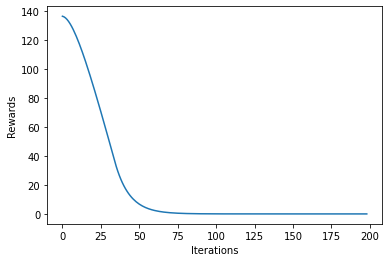

Epochs : 199 ############## Rewards : 0.28284271247461906


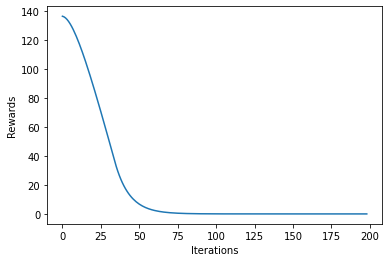

In [46]:
for i_episode in range(MAX_ITERS):
    plotter.plot(smoothed_reward.get())
    r1.restart_robot()
    
    
    while True:
        if r1.process_count >= 200:
            break
        r1.update()
    
    


    encoded_actions = np.array(action_encoder(r1.choosed_direction))
    robot_observations = np.array(r1.data_points)
    discounted_rewards = np.array(r1.data_losses)
    smoothed_reward.append(np.sum(discounted_rewards))
    
    
    out_str = "Epochs : "+str(i_episode)+ " ############## Rewards : "+str(np.sum(discounted_rewards))
    print(out_str)
    
    train_step(r1.model,optimizer,robot_observations,encoded_actions,discounted_rewards)


In [47]:
r1.model.save("test_model.h5")